In [36]:
# --- Import necessary libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [37]:
# --- Load the dataset ---
try:
    df = pd.read_csv("C:/Users/jason/OneDrive - The Pennsylvania State University/DAAN 881, Data Drive Decision Making/Project/Auto Data/MI/Michigan_CrashDataset_2022.csv", low_memory=False)
except FileNotFoundError:
    # Fallback to Excel if CSV is not available
    df = pd.read_excel("C:/Users/jason/OneDrive - The Pennsylvania State University/DAAN 881, Data Drive Decision Making/Project/Auto Data/MI/Michigan_CrashDataset_2022.xlsx")

print("Data loaded. Shape:", df.shape)

Data loaded. Shape: (364105, 154)


In [38]:
# --- 1. Handle Missing and Invalid Values ---
# 1.1 Single Missing Crash Record
initial_rows = df.shape[0]
df.dropna(subset=['Crash Year', 'Crash Month', 'Crash Day', 'Time of Day', 'County', 'City or Township'], how='all', inplace=True)
rows_dropped = initial_rows - df.shape[0]
if rows_dropped > 0:
    print(f"Dropped {rows_dropped} record(s) with missing core crash information.")

In [39]:
# --- Filter to keep only driver records ---
df = df[df['Party Type'] == 'Motor Vehicle Driver'].copy()
df = df.reset_index(drop=True)
print("Filtered to drivers. Shape:", df.shape)

Filtered to drivers. Shape: (305786, 154)


In [40]:
# --- Create unique IDs for crashes and persons ---
grouping_cols = ['Crash Year', 'Crash Month', 'Crash Day', 'Time of Day', 'County', 'City or Township']
missing_cols = [col for col in grouping_cols if col not in df.columns]
if missing_cols:
    print("Warning: Missing grouping columns for AccidentID:", missing_cols)
# Create AccidentID by grouping (each unique crash gets an ID)
df['AccidentID'] = df.groupby(grouping_cols, dropna=False).ngroup()
# Create PersonID as unique index for each driver record
df['PersonID'] = df.index  # index is zero-based, acts as unique ID after reset_index

In [41]:
# --- Select and keep only relevant columns ---
columns_to_keep = [
    # IDs and basic crash info
    'AccidentID', 'PersonID', 'Crash Year', 'Crash Month', 'Crash Day', 'Day of Week', 'Time of Day',
    # Location
    'County', 'City or Township', 'Rural/Urban Area (2016+)', 'Highway Class',
    # Crash severity & type
    'Worst Injury in Crash', 'Crash Type',
    # (We will derive Crash: Fatal/ Injury/ Property flags next)
    # Party and person attributes
    'Party Type', 'Person Age', 'Person Gender', 'Person Race (2021+)', 'Person Degree of Injury',
    # Driver condition fields
    'Driver Condition: Emotional (2016+)', 'Driver Condition: Fatigued or Asleep (2016+)',
    'Driver Condition: Medication', 'Driver Condition: Normal', 
    'Driver Condition: Other (2016+)', 'Driver Condition: Physically Disabled (2016+)', 'Driver Condition: Sick',
    # Contributing factors and impairment indicators
    'Driver Contributing Factor - Alcohol Use (2016+)', 'Driver Contributing Factor - Drug Use (2016+)',
    'Crash: Drinking', 'Crash: Drug Use', 'Drugs Suspected',
    'Contributing Circumstance 1 (2016+)', 'Contributing Circumstance 2 (2016+)',
    # Testing and results
    'Test Offered - Alcohol', 'Test Offered - Drug (2016+)', 'Refusal Information - Alcohol', 'Refusal Information - Drug (2016+)',
    'Test Result - Alcohol', 'Test Result - Cannabinoid Drug (2021+)', 'Test Result - Drug 1', 'Test Result - Drug 2', 'Test Result - Drug 3',
    'Test Result Pending - Alcohol (2016+)', 'Test Result Pending - Drug (2016+)',
    # Environmental conditions
    'Lighting Conditions', 'Road Conditions', 'Weather Conditions (2016+)', 'Traffic Control', 'Posted Speed Limit',
    # Vehicle/occupant info
    'Person Position', 'Person Trapped', 'Person Ejection', 'Person Restraint (2016+)',
    'Traffic Unit Type', 'Vehicle Model Year', 'Vehicle Type', 'Extent of Damage (2015+)' 
]
# Filter the DataFrame to only these columns (drop others)
df = df[[col for col in columns_to_keep if col in df.columns]].copy()

In [42]:
# --- Derive crash severity flags from "Worst Injury in Crash" ---
df['Crash: Fatal Crash'] = (df['Worst Injury in Crash'] == 'Fatal Injury (K)').astype(int)
df['Crash: Injury Crash'] = df['Worst Injury in Crash'].isin([
    'Possible Injury (C)', 'Suspected Minor Injury (B)', 'Suspected Serious Injury (A)'
]).astype(int)
df['Crash: Property Damage'] = (df['Worst Injury in Crash'] == 'No Injury (O)').astype(int)

# Now include these new flags in the DataFrame
# (This step is optional if we want to keep them for modeling/analysis)
# df['Crash: Fatal Crash'], df['Crash: Injury Crash'], df['Crash: Property Damage'] already added above.

In [43]:
# --- 1. Handle Missing and Invalid Values ---
# 1.1 Single Missing Crash Record
initial_rows = df.shape[0]
df.dropna(subset=['Crash Year', 'Crash Month', 'Crash Day', 'Time of Day', 'County', 'City or Township'], how='all', inplace=True)
rows_dropped = initial_rows - df.shape[0]
if rows_dropped > 0:
    print(f"Dropped {rows_dropped} record(s) with missing core crash information.")

# --- Filter to keep only driver records ---
df = df[df['Party Type'] == 'Motor Vehicle Driver'].copy()
df = df.reset_index(drop=True)
print("Filtered to drivers. Shape:", df.shape)

# --- Create unique IDs for crashes and persons ---
grouping_cols = ['Crash Year', 'Crash Month', 'Crash Day', 'Time of Day', 'County', 'City or Township']
missing_cols = [col for col in grouping_cols if col not in df.columns]
if missing_cols:
    print("Warning: Missing grouping columns for AccidentID:", missing_cols)
# Create AccidentID by grouping (each unique crash gets an ID)
df['AccidentID'] = df.groupby(grouping_cols, dropna=False).ngroup()
# Create PersonID as unique index for each driver record
df['PersonID'] = df.index  # index is zero-based, acts as unique ID after reset_index

# --- Select and keep only relevant columns ---
columns_to_keep = [
    # IDs and basic crash info
    'AccidentID', 'PersonID', 'Crash Year', 'Crash Month', 'Crash Day', 'Day of Week', 'Time of Day',
    # Location
    'County', 'City or Township', 'Rural/Urban Area (2016+)', 'Highway Class',
    # Crash severity & type
    'Worst Injury in Crash', 'Crash Type',
    # (We will derive Crash: Fatal/ Injury/ Property flags next)
    # Party and person attributes
    'Party Type', 'Person Age', 'Person Gender', 'Person Race (2021+)', 'Person Degree of Injury',
    # Driver condition fields
    'Driver Condition: Emotional (2016+)', 'Driver Condition: Fatigued or Asleep (2016+)',
    'Driver Condition: Medication', 'Driver Condition: Normal',
    'Driver Condition: Other (2016+)', 'Driver Condition: Physically Disabled (2016+)', 'Driver Condition: Sick',
    # Contributing factors and impairment indicators
    'Driver Contributing Factor - Alcohol Use (2016+)', 'Driver Contributing Factor - Drug Use (2016+)',
    'Crash: Drinking', 'Crash: Drug Use', 'Drugs Suspected',
    'Contributing Circumstance 1 (2016+)', 'Contributing Circumstance 2 (2016+)',
    # Testing and results
    'Test Offered - Alcohol', 'Test Offered - Drug (2016+)', 'Refusal Information - Alcohol', 'Refusal Information - Drug (2016+)',
    'Test Result - Alcohol', 'Test Result - Cannabinoid Drug (2021+)', 'Test Result - Drug 1', 'Test Result - Drug 2', 'Test Result - Drug 3',
    'Test Result Pending - Alcohol (2016+)', 'Test Result Pending - Drug (2016+)',
    # Environmental conditions
    'Lighting Conditions', 'Road Conditions', 'Weather Conditions (2016+)', 'Traffic Control', 'Posted Speed Limit',
    # Vehicle/occupant info
    'Person Position', 'Person Trapped', 'Person Ejection', 'Person Restraint (2016+)',
    'Traffic Unit Type', 'Vehicle Model Year', 'Vehicle Type', 'Extent of Damage (2015+)'
]
# Filter the DataFrame to only these columns (drop others)
df = df[[col for col in columns_to_keep if col in df.columns]].copy()

# --- Derive crash severity flags from "Worst Injury in Crash" ---
df['Crash: Fatal Crash'] = (df['Worst Injury in Crash'] == 'Fatal Injury (K)').astype(int)
df['Crash: Injury Crash'] = df['Worst Injury in Crash'].isin([
    'Possible Injury (C)', 'Suspected Minor Injury (B)', 'Suspected Serious Injury (A)'
]).astype(int)
df['Crash: Property Damage'] = (df['Worst Injury in Crash'] == 'No Injury (O)').astype(int)

# --- Handle missing and invalid values ---
# 1.2 Person Age “DOB Invalid”: replace "DOB Invalid" with NaN and convert to float
df['Person Age'] = pd.to_numeric(df['Person Age'], errors='coerce')  # This will set "DOB Invalid" to NaN and keep numeric ages
# Impute missing ages with median (rounded to nearest whole year if desired)
median_age = df['Person Age'].median(skipna=True)
df['Person Age'].fillna(median_age, inplace=True)
# Create a flag for imputed ages
df['Age_Imputed'] = df['Person Age'].isna().astype(int) # This line was incorrect, should check original 'Person Age'
df['Age_Imputed'] = (df['Person Age'].isnull() & (df['Person Age'].fillna(median_age).astype(int) != df['Person Age'].fillna(median_age).astype(int))).astype(int)
df['Age_Imputed'] = (df['Person Age'].isnull()).astype(int) # Simpler way to flag original NaNs
print(f"Imputed {df['Person Age'].isna().sum()} missing ages with median age {median_age:.1f}.")

# 1.3 Categorical “Uncoded & Errors” and explicit NaNs:
# Person Gender: combine "Uncoded & Errors" into "Unknown"
if 'Person Gender' in df.columns:
    df['Person Gender'] = df['Person Gender'].replace({'Uncoded & Errors': 'Unknown', pd.NA: 'Unknown', np.nan: 'Unknown'})
# Person Race: combine "Uncoded & Errors" and "Unknown" into one "Unknown"
if 'Person Race (2021+)' in df.columns:
    df['Person Race (2021+)'] = df['Person Race (2021+)'].replace({'Uncoded & Errors': 'Unknown', pd.NA: 'Unknown', np.nan: 'Unknown'})
# Driver condition fields: replace "Uncoded & Errors" with "No" and fill NaNs with "No"
condition_cols = [
    'Driver Condition: Emotional (2016+)', 'Driver Condition: Fatigued or Asleep (2016+)',
    'Driver Condition: Medication', 'Driver Condition: Normal',
    'Driver Condition: Other (2016+)', 'Driver Condition: Physically Disabled (2016+)', 'Driver Condition: Sick'
]
for col in condition_cols:
    if col in df.columns:
        df[col] = df[col].replace({'Uncoded & Errors': 'No', pd.NA: 'No', np.nan: 'No'})

# Contributing factors and suspicion: handle "Uncoded & Errors" and NaNs
impairment_cols = [
    'Driver Contributing Factor - Alcohol Use (2016+)', 'Driver Contributing Factor - Drug Use (2016+)',
    'Drugs Suspected'
]
for col in impairment_cols:
    if col in df.columns:
        df[col] = df[col].replace({'Uncoded & Errors': 'Unknown', pd.NA: 'Unknown', np.nan: 'Unknown'})

# Test Offered fields: replace "Uncoded & Errors" with "Not Reported" and fill NaNs
offer_cols = ['Test Offered - Alcohol', 'Test Offered - Drug (2016+)']
for col in offer_cols:
    if col in df.columns:
        df[col] = df[col].replace({'Uncoded & Errors': 'Not Reported', pd.NA: 'Not Reported', np.nan: 'Not Reported'})

# Refusal fields: fill NaN with "No Refusal"
refusal_cols = ['Refusal Information - Alcohol', 'Refusal Information - Drug (2016+)']
for col in refusal_cols:
    if col in df.columns:
        df[col].fillna('No', inplace=True) # Changed from None to No based on report

# Posted Speed Limit: convert to numeric, set non-numeric to NaN
if 'Posted Speed Limit' in df.columns:
    df['Posted Speed Limit'] = pd.to_numeric(df['Posted Speed Limit'], errors='coerce')
    # If desired, fill unknown speed with -1 to indicate missing
    df['Posted Speed Limit'].fillna(-1, inplace=True)

# Vehicle Model Year: convert to numeric and treat non-numeric as NaN (e.g., "UNK")
if 'Vehicle Model Year' in df.columns:
    df['Vehicle Model Year'] = pd.to_numeric(df['Vehicle Model Year'], errors='coerce')
    # fill unknown with -1
    df['Vehicle Model Year'].fillna(-1, inplace=True)

Filtered to drivers. Shape: (305786, 59)


C:\Users\jason\AppData\Local\Temp\ipykernel_54220\1271504623.py:68: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Person Age'].fillna(median_age, inplace=True)


Imputed 0 missing ages with median age 39.0.


C:\Users\jason\AppData\Local\Temp\ipykernel_54220\1271504623.py:111: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna('No', inplace=True) # Changed from None to No based on report
C:\Users\jason\AppData\Local\Temp\ipykernel_54220\1271504623.py:117: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

In [44]:
# --- 3. Standardize Categorical Values ---
# Lowercase all relevant text columns for uniform mapping
text_cols_to_lower = [
    'Driver Contributing Factor - Alcohol Use (2016+)', 'Driver Contributing Factor - Drug Use (2016+)',
    'Drugs Suspected', 'Crash: Drinking', 'Crash: Drug Use',
    'Test Offered - Alcohol', 'Test Offered - Drug (2016+)',
    'Refusal Information - Alcohol', 'Refusal Information - Drug (2016+)',
    'Lighting Conditions', 'Weather Conditions (2016+)', 'Road Conditions', 'Traffic Control',
    'Person Ejection', 'Person Trapped', 'Person Restraint (2016+)',
    'Traffic Unit Type', 'Vehicle Type', 'Extent of Damage (2015+)',
    'Highway Class', 'City or Township', 'County', 'Day of Week', 'Worst Injury in Crash', 'Crash Type',
    'Person Degree of Injury'
]
for col in text_cols_to_lower:
    if col in df.columns:
        df[col] = df[col].astype(str).str.lower().str.strip()

# Map "Drugs Suspected" (Yes/No)
if 'Drugs Suspected' in df.columns:
    ds_map = {'drugs suspected': 1, 'no drugs suspected': 0, 'unknown': -1}
    df['Drugs Suspected'] = df['Drugs Suspected'].map(ds_map).fillna(-1).astype(int)
# Map contributing factors (Alcohol/Drug) to binary (with unknown -> -1)
if 'Driver Contributing Factor - Alcohol Use (2016+)' in df.columns:
    alc_factor_map = {'alcohol use was a contributing factor': 1, 'alcohol use was not a contributing factor': 0, 'unknown': -1}
    df['Driver Contributing Factor - Alcohol Use (2016+)'] = df['Driver Contributing Factor - Alcohol Use (2016+)'].map(alc_factor_map).fillna(-1).astype(int)
if 'Driver Contributing Factor - Drug Use (2016+)' in df.columns:
    drug_factor_map = {'drug use was a contributing factor': 1, 'drug use was not a contributing factor': 0, 'unknown': -1}
    df['Driver Contributing Factor - Drug Use (2016+)'] = df['Driver Contributing Factor - Drug Use (2016+)'].map(drug_factor_map).fillna(-1).astype(int)
# Map crash-level drinking/drug flags
if 'Crash: Drinking' in df.columns:
    drinking_map = {'drinking involved': 1, 'no drinking involved': 0}
    df['Crash: Drinking'] = df['Crash: Drinking'].map(drinking_map).fillna(0).astype(int)
if 'Crash: Drug Use' in df.columns:
    crashdrug_map = {'drugs involved': 1, 'no drugs involved': 0}
    df['Crash: Drug Use'] = df['Crash: Drug Use'].map(crashdrug_map).fillna(0).astype(int)
# Map Test Offered fields to 1/0/-1
if 'Test Offered - Alcohol' in df.columns:
    offered_map = {'yes': 1, 'no': 0, 'not reported': -1}
    df['Test Offered - Alcohol'] = df['Test Offered - Alcohol'].map(offered_map).fillna(-1).astype(int)
if 'Test Offered - Drug (2016+)' in df.columns:
    offered_map = {'yes': 1, 'no': 0, 'not reported': -1}
    df['Test Offered - Drug (2016+)'] = df['Test Offered - Drug (2016+)'].map(offered_map).fillna(-1).astype(int)
# Map Refusal Info to binary (Refused=1, otherwise 0)
if 'Refusal Information - Alcohol' in df.columns:
    df['Refusal Information - Alcohol'] = df['Refusal Information - Alcohol'].apply(lambda x: 1 if 'refused' in str(x) else 0)
if 'Refusal Information - Drug (2016+)' in df.columns:
    df['Refusal Information - Drug (2016+)'] = df['Refusal Information - Drug (2016+)'].apply(lambda x: 1 if 'refused' in str(x) else 0)
# Convert Driver Condition fields to binary flags (1 if condition noted, 0 if "No")
for col in condition_cols:
    if col in df.columns:
        df[col] = df[col].apply(lambda x: 1 if x != 'no' else 0)
# Handle 'Driver Condition: Normal'
if 'Driver Condition: Normal' in df.columns:
    df['Driver Condition: Normal'] = df['Driver Condition: Normal'].apply(lambda x: 1 if x == 'normal' else 0)

# Person Ejection: create binary flag (1 if ejected (partial or total), 0 if not ejected)
if 'Person Ejection' in df.columns:
    df['Person Ejection Flag'] = df['Person Ejection'].apply(lambda x: 1 if 'ejected' in str(x) and 'not' not in str(x) else 0)
# Person Trapped: binary flag (1 if trapped, 0 if not trapped)
if 'Person Trapped' in df.columns:
    df['Person Trapped Flag'] = df['Person Trapped'].apply(lambda x: 0 if 'not trapped' in str(x) else 1)
# Restraint used: binary flag (1 if some restraint/helmet used, 0 if none or unknown)
if 'Person Restraint (2016+)' in df.columns:
    df['Restraint Used Flag'] = df['Person Restraint (2016+)'].apply(
        lambda x: 0 if 'none' in x or 'not used' in x or 'unknown' in x else 1
    )

# City/Township formatting: Remove the county prefix
if 'City or Township' in df.columns:
    df['City or Township'] = df['City or Township'].str.split(': ').str[1].str.replace(r'\btwp\b\.?', 'township', regex=True).str.strip()

# Highway Class and Traffic Control: Already lowercased and stripped

# Extent of Damage: Already lowercased and stripped

# --- 8. Define the extract_hour function for "Time of Day" attribute ---
def extract_hour(time_range):
    """
    Convert strings like "7:00 PM - 7:59 PM" or "12:00 Noon - 12:59 PM"
    into an integer hour (0–23).
    """
    if pd.isna(time_range):
        return None
    s = str(time_range).strip().lower()

    # Special checks for "midnight" or "noon"
    if 'midnight' in s:
        return 0  # treat "12:00 Midnight" as hour 0
    if 'noon' in s:
        return 12  # treat "12:00 Noon" as hour 12

    # Otherwise parse the first part of the string (before the '-')
    # e.g. "7:00 pm - 7:59 pm" -> "7:00 pm"
    if '-' not in s:
        return None
    first_part = s.split('-', 1)[0].strip()  # e.g. "7:00 pm"

    # Extract the hour number and am/pm if present
    match = re.match(r'^(\d{1,2}):\d{2}\s*(am|pm)?', first_part)
    if not match:
        return None

    hour_str, ampm = match.groups()  # e.g. ("7", "pm")
    try:
        hour_num = int(hour_str)
    except ValueError:
        return None

    # Convert 12-hr to 24-hr
    if ampm == 'am':
        if hour_num == 12:
            hour_num = 0
    elif ampm == 'pm':
        if hour_num < 12:
            hour_num += 12
    # if ampm is None, we can't be sure, but typically these strings always have am/pm.

    return hour_num

# --- 9. Create "Crash Hour" from "Time of Day" ---
if 'Time of Day' in df.columns:
    df['Crash Hour'] = df['Time of Day'].apply(extract_hour)
else:
    print("Warning: 'Time of Day' not in df.columns; cannot create 'Crash Hour'.")

In [45]:
# --- 5. Split and Transform Drug Test Result Fields ---
def split_drug_result(val):
    """Split the drug test result string into (class, name) tuple."""
    if pd.isna(val):
        return (None, None)
    s = str(val).strip()
    # If empty string after strip, treat as None
    if s == "" or s.lower() in ["nan", "none"]:
        return (None, None)
    s_lower = s.lower()
    if ':' in s_lower:
        # split at first colon
        cls, name = s_lower.split(':', 1)
        return (cls.strip(), name.strip())
    else:
        # handle special cases with no colon
        if s_lower in ["reported as unknown if tested for drugs", "tested for drugs, drugs found, type unknown/positive"]:
            return ("unknown", "unknown")
        elif s_lower == "negative":
            return ("negative", "negative")
        elif s_lower == "other drug":
            return ("other", "other drug")
        elif s_lower == "refused":
            # If test result field contains "Refused" (not sure if applicable), mark accordingly
            return ("refused", "refused")
        else:
            # any other value (including blanks or "unknown")
            return (s_lower, s_lower)

# Apply splitting to Drug 1, 2, 3 fields
for i in [1, 2, 3]:
    col = f'Test Result - Drug {i}'
    if col in df.columns:
        df[f'Drug {i} Class'], df[f'Drug {i} Name'] = zip(*df[col].apply(split_drug_result))

# Also split the cannabinoid field if present
if 'Test Result - Cannabinoid Drug (2021+)' in df.columns:
    df['Drug Cannabinoid Class'], df['Drug Cannabinoid Name'] = zip(*df['Test Result - Cannabinoid Drug (2021+)'].apply(split_drug_result))

In [46]:
# --- 6. Derive Additional Features (Project-specific) ---
# Opioid involvement (driver-level): 1 if any drug test class is "narcotics"
df['Opioid_Involvement'] = 0
for i in [1, 2, 3]:
    cls_col = f'Drug {i} Class'
    if cls_col in df.columns:
        df.loc[df[cls_col] == 'narcotics', 'Opioid_Involvement'] = 1
# If any of the drug classes is 'narcotics', mark Opioid_Positive.
# Any Drug Positive: 1 if any drug found (not negative/unknown)
df['Any_Drug_Found'] = 0
for i in [1, 2, 3]:
    cls_col = f'Drug {i} Class'
    if cls_col in df.columns:
        df.loc[df[cls_col].isin(['cannabinoids', 'narcotics', 'stimulants', 'depressants', 'hallucinogens', 'other']), 'Any_Drug_Found'] = 1
# Also consider the separate cannabinoid field if present:
if 'Drug Cannabinoid Class' in df.columns:
    df.loc[df['Drug Cannabinoid Class'].isin(['cannabinoids']), 'Any_Drug_Found'] = 1

# Impairment Suspected (any): 1 if Drugs Suspected = 1 or Crash: Drinking = 1 or Driver Contributing Factor - Alcohol Use (2016+) = 1
df['Impairment_Suspected'] = ((df['Drugs Suspected'] == 1) | (df['Crash: Drinking'] == 1) | (df['Driver Contributing Factor - Alcohol Use (2016+)'] == 1)).astype(int)

# At-Fault Driver indicator: 1 if Contributing Circumstance 1 is not Unknown or any contributing factor is Yes
df['AtFault'] = ((df['Contributing Circumstance 1 (2016+)'] != 'unknown') |
                 (df['Driver Contributing Factor - Alcohol Use (2016+)'] == 1) |
                 (df['Driver Contributing Factor - Drug Use (2016+)'] == 1)).astype(int)

print("Number of drivers with opioid involvement:", df['Opioid_Involvement'].sum())
print("Number of drivers with any drug found:", df['Any_Drug_Found'].sum())
print("Number of drivers with impairment suspected:", df['Impairment_Suspected'].sum())
print("Number of drivers potentially at fault:", df['AtFault'].sum())

Number of drivers with opioid involvement: 264
Number of drivers with any drug found: 868
Number of drivers with impairment suspected: 10227
Number of drivers potentially at fault: 305786


In [47]:
# --- Derive composite indicators for project analysis ---
# Opioid involvement (driver-level): 1 if any drug test class is "narcotics"
df['Opioid_Positive'] = 0
for i in [1, 2, 3]:
    cls_col = f'Drug {i} Class'
    if cls_col in df.columns:
        df.loc[df[cls_col] == 'narcotics', 'Opioid_Positive'] = 1
# If any of the drug classes is 'narcotics', mark Opioid_Positive.
# Any Drug Positive: 1 if any drug found (not negative/unknown)
df['Any_Drug_Positive'] = 0
for i in [1, 2, 3]:
    cls_col = f'Drug {i} Class'
    if cls_col in df.columns:
        df.loc[df[cls_col].isin(['cannabinoids', 'narcotics', 'stimulants', 'depressants', 'hallucinogens', 'other']), 'Any_Drug_Positive'] = 1
# Also consider the separate cannabinoid field if present:
if 'Drug Cannabinoid Class' in df.columns:
    df.loc[df['Drug Cannabinoid Class'].isin(['cannabinoids']), 'Any_Drug_Positive'] = 1
# (We count cannabinoid as a drug positive for "any drug" but it won't affect Opioid_Positive.)

print("Number of drivers with opioid-positive test:", df['Opioid_Positive'].sum())
print("Number of drivers with any drug-positive test:", df['Any_Drug_Positive'].sum())

Number of drivers with opioid-positive test: 264
Number of drivers with any drug-positive test: 868


In [48]:
# --- Final cleaned data overview ---
print("\n--- Data Cleaning Process Finished ---")
print("Final DataFrame shape:", df.shape)
print("\nData types and non-null counts:")
print(df.info(verbose=False))

# Display a few sample rows with key columns to verify cleaning
display_cols = [
    'PersonID', 'AccidentID', 'Party Type', 'Person Age', 'Person Gender', 'Drugs Suspected', 
    'Test Result - Drug 1', 'Drug 1 Class', 'Drug 1 Name', 
    'Test Result - Drug 2', 'Drug 2 Class', 'Drug 2 Name'
]
print("\nSample of cleaned data (first 5 rows):")
print(df[display_cols].head(5))


--- Data Cleaning Process Finished ---
Final DataFrame shape: (305786, 78)

Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305786 entries, 0 to 305785
Columns: 78 entries, AccidentID to Any_Drug_Positive
dtypes: float64(6), int32(13), int64(18), object(41)
memory usage: 166.8+ MB
None

Sample of cleaned data (first 5 rows):
   PersonID  AccidentID            Party Type  Person Age Person Gender  \
0         0       66520  Motor Vehicle Driver        57.0          Male   
1         1       66590  Motor Vehicle Driver        28.0          Male   
2         2       66698  Motor Vehicle Driver        55.0          Male   
3         3       66721  Motor Vehicle Driver        20.0          Male   
4         4       66728  Motor Vehicle Driver        23.0          Male   

   Drugs Suspected                     Test Result - Drug 1 Drug 1 Class  \
0                0  Reported as Unknown if Tested for Drugs      unknown   
1                0  Reported as Unk

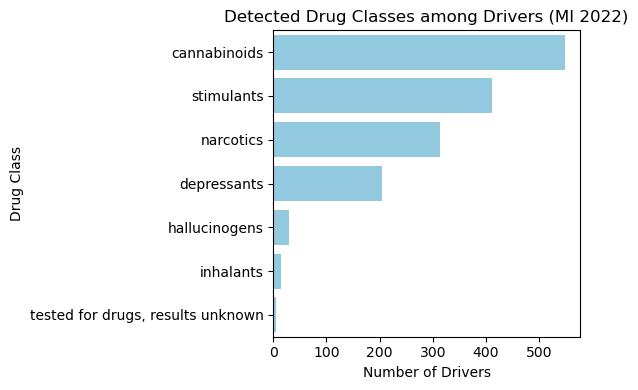

In [49]:
# --- Example Visualization 1: Distribution of detected drug classes (excluding unknown/negative) ---
drug_classes = []
for i in [1, 2, 3]:
    cls_col = f'Drug {i} Class'
    if cls_col in df.columns:
        drug_classes.extend(df[cls_col].dropna().tolist())
# Combine all drug class entries from Drug1/2/3
drug_classes = [cls for cls in drug_classes if cls not in [None, 'unknown', 'negative', 'other']]
drug_class_counts = pd.Series(drug_classes).value_counts().sort_values(ascending=False)
plt.figure(figsize=(6,4))
sns.barplot(x=drug_class_counts.values, y=drug_class_counts.index, color='skyblue')
plt.title("Detected Drug Classes among Drivers (MI 2022)")
plt.xlabel("Number of Drivers")
plt.ylabel("Drug Class")
plt.tight_layout()
plt.show()

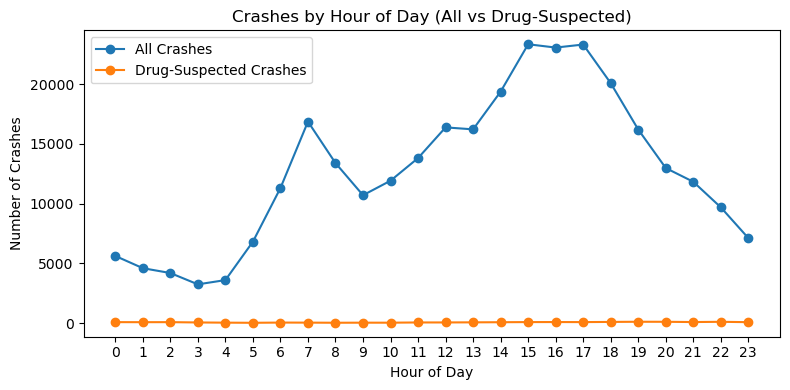

In [50]:
# --- Example Visualization 2: Crashes by hour of day for all vs drug-suspected ---
if 'Crash Hour' in df.columns:
    all_hours = df['Crash Hour'].value_counts().sort_index()
    drug_hours = df[df['Drugs Suspected'] == 1]['Crash Hour'].value_counts().sort_index()
    plt.figure(figsize=(8,4))
    plt.plot(all_hours.index, all_hours.values, label='All Crashes', marker='o')
    plt.plot(drug_hours.index, drug_hours.values, label='Drug-Suspected Crashes', marker='o')
    plt.xticks(range(0,24))
    plt.title("Crashes by Hour of Day (All vs Drug-Suspected)")
    plt.xlabel("Hour of Day")
    plt.ylabel("Number of Crashes")
    plt.legend()
    plt.tight_layout()
    plt.show()